# Notebook to visualize protein predictions

<ipython-input-10-a610f3ab93d0>:208: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_minor_formatter(ticker.FixedFormatter(resn_labels))


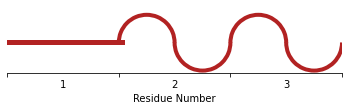

In [10]:
"""
Draws a SS plot, representing strands as arrows and helices as waves from
a SS-containing file (H/E/etc). Turns are drawn as single arcs.
Example Input:
 1  C
 2  H
 3  H
 4  H
 5  H
 6  C
 7  C
 8  E
 9  E
10  E
11  E
12  C
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import matplotlib.ticker as ticker

example= [
    [1, "C"],
    [2, "H"],
    [3, "H"]]

ss_elements, resn_labels = [], []
for line in example:
    resn, ss = line
    ss_elements.append(ss)
    resn_labels.append(resn)

n_res = len(ss_elements)

# Reduce SS
ss_dict = {'H': 'H', 'G': 'H', 'I': 'H',
           'B': 'E', 'E': 'E',
           'T': 'T', 'S': 'T'}

# Get strecthes of continuous elements
ss_blocks = []  # (type, start, end)
prev_ss = None
for idx, elem in enumerate(ss_elements):
    reduced_elem = ss_dict.get(elem, 'C')
    if reduced_elem != prev_ss:
        ss_blocks.append([reduced_elem, idx, idx])
        prev_ss = reduced_elem

    ss_blocks[-1][-1] = idx

# Sort to get helices first, strands last: so the overlapping works
# _ss_order = {'H': 1, 'E': 2, 'C': 0}
# ss_blocks.sort(key=lambda x: _ss_order.get(x[0]))


#
# Make plot
#

fig = plt.figure()
ax = fig.add_subplot(111)

# Set x-axis
x_axis_ticks = np.arange(n_res + 1)

# General settings
helix_as_wave = True
helix_as_cylinder = False

fc_sheet = 'firebrick'
fc_helix = 'firebrick'
fc_coil = 'firebrick'
ec = 'none'

width = 1.0  # General width controller
helix_arc_width = 4.0
coil_thickness_factor = 1/12
edge_thickness = 1.0
sheet_thickness_factor = 2/3
turn_thickness_factor = 1/2

# Draw artists
width = 1.0
for blk_idx, ss_blk in enumerate(ss_blocks):
    ss_type, start, last = ss_blk

    if helix_as_cylinder and ss_type == 'H':
        # Draw rectangle capped by two elipses
        # Elipse width = 1 residue
        # Origin is *center* of elipse

        # Order of drawing matters for overlap

        # First elipse
        elength = width / 2  # horizontal diameter
        height = width - 0.001  # vertical axis (slight offset bc of edge)
        origin = (start + elength/2, height/2)

        e = mpl_patches.Ellipse(origin, elength, height,
                                linewidth=edge_thickness,
                                edgecolor='black', facecolor=fc_helix)
        ax.add_patch(e)

        # Rectangle(s)
        length = last - start + 1 - elength  # deduct l of the ellipses
        height = width  # rectangle width is fraction of global
        origin = (start + elength/2, 0)  # origin is lower left: make it v-cntr

        e = mpl_patches.Rectangle(origin, length, height,
                                  edgecolor='none', facecolor=fc_helix)
        ax.add_patch(e)

        # Second elipse
        height = width - 0.001  # vertical axis
        origin = (last + 1 - elength/2, height/2)
        e = mpl_patches.Ellipse(origin, elength, height,
                                linewidth=edge_thickness,
                                edgecolor='black', facecolor=fc_helix)

        ax.add_patch(e)

    elif helix_as_wave and ss_type == 'H':
        # Draw as consecutive elyptical arcs
        height = width
        length = 0.5
        st_theta, en_theta = 0, 180
        for t_start in np.arange(start, last + 1, length):  # turns
            origin = (t_start + 0.25, height/2)
            e = mpl_patches.Arc(origin, length, height,
                                linewidth=helix_arc_width,
                                # Add a bit to each angle to avoid sharp cuts
                                # that show as white lines in plot
                                theta1=st_theta - 1, theta2=en_theta + 1,
                                edgecolor=fc_helix)

            st_theta += 180
            en_theta += 180
            ax.add_patch(e)

    elif ss_type == 'E':
        # Draw arrow
        length = last - start + 1
        tail_height = width * sheet_thickness_factor
        head_height = width

        e = mpl_patches.FancyArrow(start, width/2,  # x, y of tail
                                   length, 0,  # dx, dy=0 -> flat arrow
                                   length_includes_head=True,
                                   head_length=length/4,
                                   head_width=head_height - 0.001,
                                   width=tail_height,
                                   facecolor=fc_sheet,
                                   edgecolor=ec,
                                   linewidth=edge_thickness)
        ax.add_patch(e)

    elif ss_type == 'T':
        # Draw turn as thin arc
        height = width
        length = last - start + 1
        st_theta, en_theta = 0, 180
        origin = (start + length / 2, height/2)
        e = mpl_patches.Arc(origin, length, height,
                            linewidth=helix_arc_width,
                            theta1=st_theta, theta2=en_theta,
                            edgecolor=fc_helix)

        ax.add_patch(e)

    else:  # draw line (thin Rectangle)
        length = last - start + 1
        height = width * coil_thickness_factor

        # Offset ends to fake continuity
        prev_blk_type = ss_blocks[blk_idx - 1][0]
        if prev_blk_type in ('H', 'T'):
            # Rougly the same size as the linewidth
            start -= 4/72
            length += 4/72
        elif prev_blk_type == 'E':
            # Go wild
            start -= 0.5
            length += 0.5

        if (blk_idx + 1) < len(ss_blocks):
            next_blk_type = ss_blocks[blk_idx + 1][0]
            if next_blk_type in ('H', 'T'):
                length += 4/72
            elif next_blk_type == 'E':
                length += 0.5

        origin = (start, width/2 - height/2)  # vertical center

        e = mpl_patches.Rectangle(origin, length, height,
                                  linewidth=edge_thickness,
                                  edgecolor=ec, facecolor=fc_coil)
        ax.add_patch(e)

# Set tick formatting
ax.set_ylim([-0.05, 1.15])
ax.set_xticks(x_axis_ticks)

ax.xaxis.set_major_formatter(ticker.NullFormatter())  # remove the major ticks
minorLocator = ticker.AutoMinorLocator(2)  # minor in between two majors
ax.xaxis.set_minor_locator(minorLocator)
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(resn_labels))

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

# ax.set_xticklabels(resn_labels, rotation=90)

# Set axis labels
ax.set_xlabel('Residue Number')

# Overall plot formatting
ax.set_aspect(0.5)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()